In [6]:
from ..helpers import *
from tensorflow.contrib.layers import flatten

ImportError: attempted relative import with no known parent package

In [283]:
def get_images(path, infer=False):
    """Get BGR images with its classes and the names of them. Also resize all images to 28x28x3."""
    img_names = os.listdir(path)
    images = []
    img_classes = []
    transformed_image_names = []
    count_images = 0
    for img_name in img_names:
        if (not img_name.startswith('.') and os.path.isfile(os.path.join(path, img_name))):
            count_images += 1
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            height, width, channels = img.shape
            max_width_height = 28
            img = cv2.resize(img, (max_width_height, max_width_height))
            images.append(img)
            img_classes.append(get_class_from_name(img_name, infer))
            transformed_image_names.append(img_name)
    return np.array(images, 'float32'), np.array(img_classes, 'float32'), transformed_image_names

def transform_input(images, labels, infer=False):
    """Zero pad the images to get a shape of 32x32x3"""
    images = np.pad(images, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    if(infer):
        enc = OneHotEncoder(43)
        try:
            labels = enc.fit_transform(labels.reshape(-1, 1)).todense()
        except:
            print('Can not train with infer data.')
    return images, labels

In [296]:
imgs, classes, tf_img_names = get_images('./images/train', infer=False)
imgs_user, classes_user = transform_input(imgs, classes, infer=False)

In [ ]:
#TODO Implement the variable learning rates that the paper proposes.
#TODO Standarize images.

In [238]:
def LeNet_5(x):
    # Layer 1 : Convolutional Layer. Input = 32x32x1, Output = 28x28x1.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,3,6],mean = 0, stddev = 0.1), name='conv1_w')
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.tanh(conv1)

    # Pooling Layer. Input = 28x28x1. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID', name='pool_1')


    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = 0, stddev = 0.1), name='conv2_w')
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.tanh(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID', name='pool_2')


    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)


    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = 0, stddev = 0.1), name='fc1_w')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b

    # TODO: Activation.
    fc1 = tf.nn.tanh(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = 0, stddev = 0.1), name='fc2_w')
    fc2_b = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.tanh(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,43), mean = 0 , stddev = 0.1), name='fc3_w')
    fc3_b = tf.Variable(tf.zeros(43), name='fc3_b')
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

In [274]:
def tf_lenet_model(x_data, y_data, mode='train'):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, shape=[None,32,32,3])
    y_ = tf.placeholder(tf.float32, shape=[None, 43])
    logits = LeNet_5(x)
    y = tf.nn.softmax(logits)
    
    var_save = [v for v in tf.trainable_variables()]
    saver = tf.train.Saver(var_save)
    with tf.Session() as sess:
        if(mode == 'train'):
            # Minimize the mean squared errors.
            loss = tf.reduce_mean(tf.square(tf.subtract(y_, y)))
            #It is supposed to be stochastic gradient descent, AdamOptimizer is similar.
            optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
            train = optimizer.minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_,1))
            accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            init = tf.global_variables_initializer()
            sess.run(init)

            #return y.eval(feed_dict={x: imgs})
            for iteration in range(100):
                avg_cost = 0.
                total_batch = int(len(imgs)/60)
                # Loop over all batches
                for i in range(total_batch):
                    batch_xs, batch_ys = random_batch(imgs, labels, 60)
                    # Fit training using batch data
                    sess.run(train, feed_dict={x: batch_xs, y_: batch_ys})
                    # Compute average loss
                    avg_cost += sess.run(loss, feed_dict={x: batch_xs, y_: batch_ys})/total_batch
                    # TODO Implement early stopping, I just got the # of iterations with hypterparameter tunning when I wanted to stop

                # Display logs per eiteration step
                if iteration % 2 == 0:
                    print ("Iteration:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(avg_cost))
            accuracy = sess.run(accuracy_operation, feed_dict={x: imgs, y_: labels})
            print('Training accuracy: ', accuracy)
            save_path = saver.save(sess, "./models/model3/model3.ckpt")
            return accuracy
        elif(mode == 'test'):
            saver.restore(sess, "./models/model3/model3.ckpt")
            predictions = tf.equal(tf.argmax(y, 1), tf.argmax(y_data, 1))
            accuracy = tf.reduce_mean(tf.cast(predictions, "float"))
            return accuracy.eval(feed_dict={x:x_data})
        elif(mode == 'infer'):
            saver.restore(sess, "./models/model3/model3.ckpt")
            predictions = tf.argmax(y, 1)
            return predictions.eval(feed_dict={x:x_data})

In [269]:
ac = tf_lenet_model(imgs, labels, 'train')

[<tf.Variable 'conv1_w:0' shape=(5, 5, 3, 6) dtype=float32_ref>, <tf.Variable 'conv1_b:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'conv2_w:0' shape=(5, 5, 6, 16) dtype=float32_ref>, <tf.Variable 'conv2_b:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'fc1_w:0' shape=(400, 120) dtype=float32_ref>, <tf.Variable 'fc1_b:0' shape=(120,) dtype=float32_ref>, <tf.Variable 'fc2_w:0' shape=(120, 84) dtype=float32_ref>, <tf.Variable 'fc2_b:0' shape=(84,) dtype=float32_ref>, <tf.Variable 'fc3_w:0' shape=(84, 43) dtype=float32_ref>, <tf.Variable 'fc3_b:0' shape=(43,) dtype=float32_ref>]
Iteration: 0001 cost= 0.021801323
Iteration: 0003 cost= 0.015850009
Iteration: 0005 cost= 0.012078117
Iteration: 0007 cost= 0.008500035
Iteration: 0009 cost= 0.005813554
Iteration: 0011 cost= 0.004607713
Iteration: 0013 cost= 0.003380370
Iteration: 0015 cost= 0.002627064
Iteration: 0017 cost= 0.001877648
Iteration: 0019 cost= 0.001423574
Iteration: 0021 cost= 0.001207095
Iteration: 0023 cost= 0.001078748
Iterat

In [271]:
y = glob(imgs_test, labels_test, 'test')

[<tf.Variable 'conv1_w:0' shape=(5, 5, 3, 6) dtype=float32_ref>, <tf.Variable 'conv1_b:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'conv2_w:0' shape=(5, 5, 6, 16) dtype=float32_ref>, <tf.Variable 'conv2_b:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'fc1_w:0' shape=(400, 120) dtype=float32_ref>, <tf.Variable 'fc1_b:0' shape=(120,) dtype=float32_ref>, <tf.Variable 'fc2_w:0' shape=(120, 84) dtype=float32_ref>, <tf.Variable 'fc2_b:0' shape=(84,) dtype=float32_ref>, <tf.Variable 'fc3_w:0' shape=(84, 43) dtype=float32_ref>, <tf.Variable 'fc3_b:0' shape=(43,) dtype=float32_ref>]
INFO:tensorflow:Restoring parameters from ./models/model3/model3.ckpt


In [290]:
imgs_user, classes_user, img_names_user = get_images('./images/test', True)

In [292]:
predsx = tf_lenet_model(imgs_user, classes_user, 'infer')

INFO:tensorflow:Restoring parameters from ./models/model3/model3.ckpt


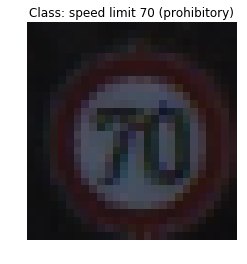

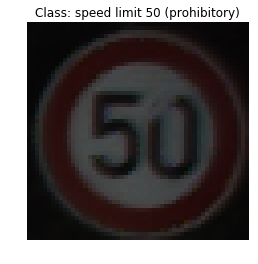

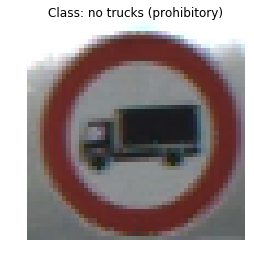

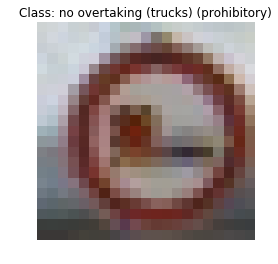

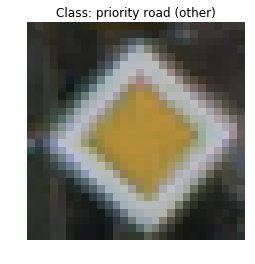

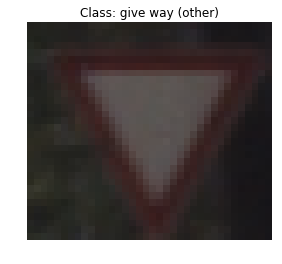

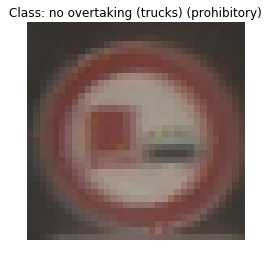

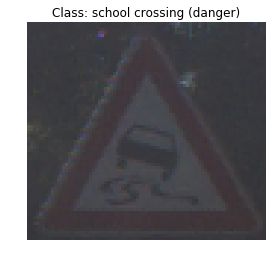

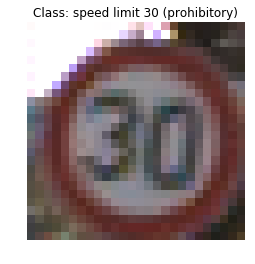

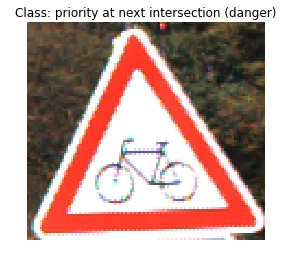

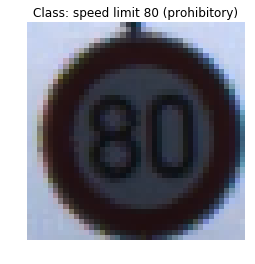

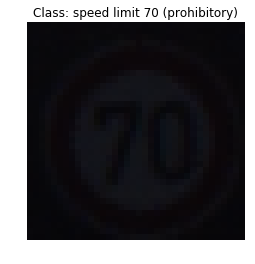

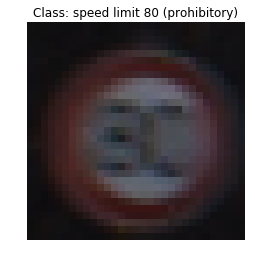

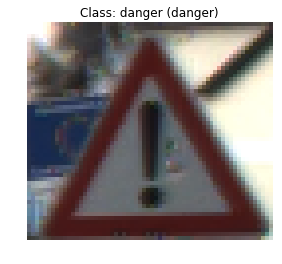

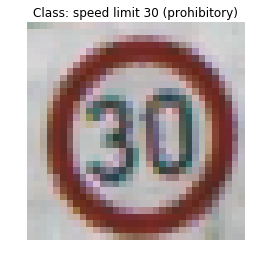

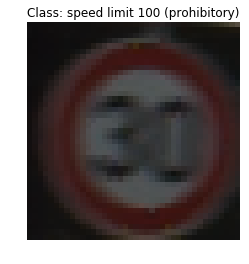

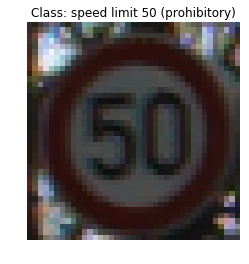

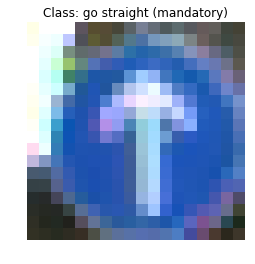

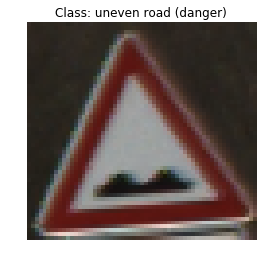

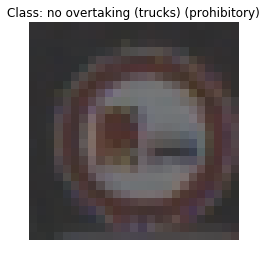

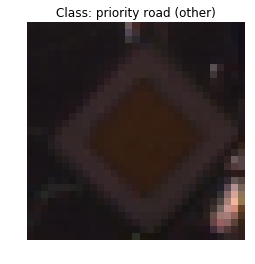

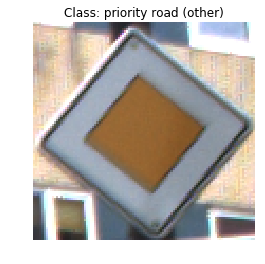

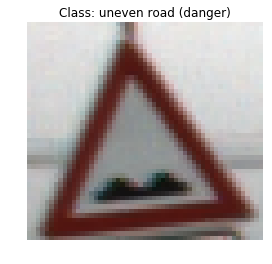

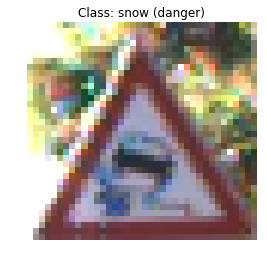

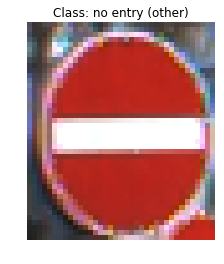

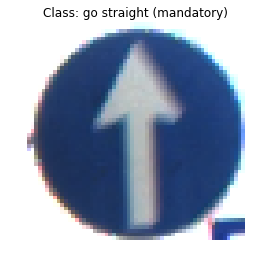

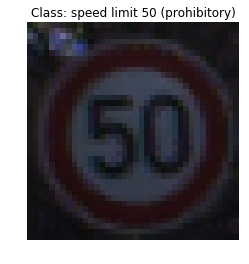

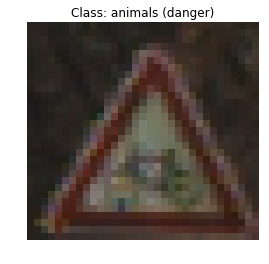

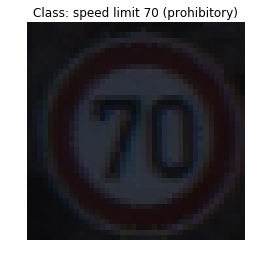

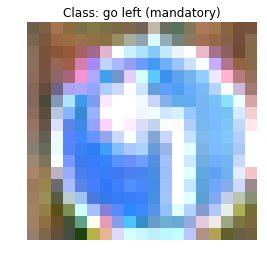

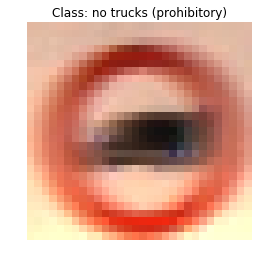

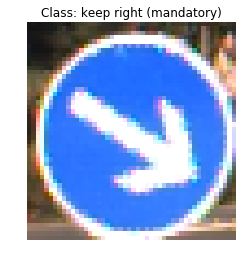

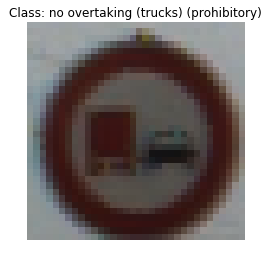

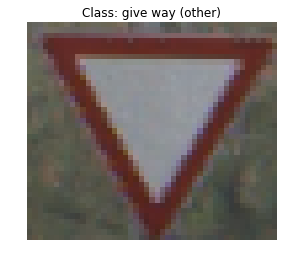

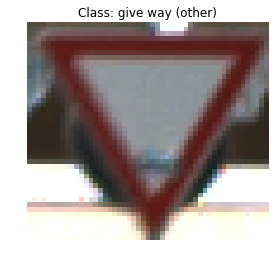

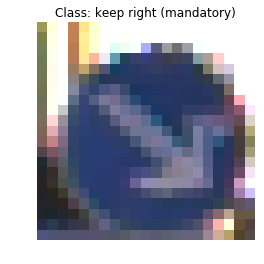

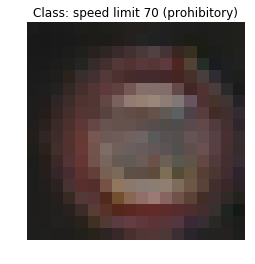

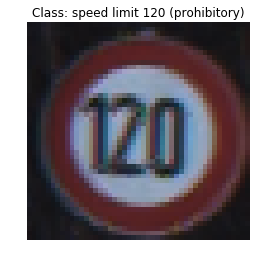

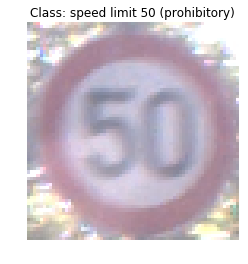

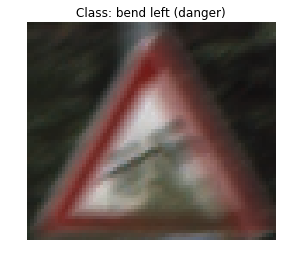

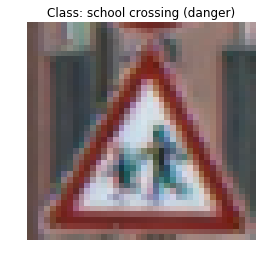

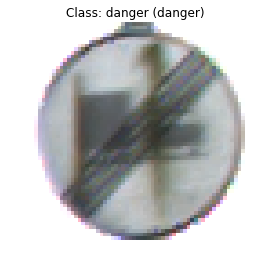

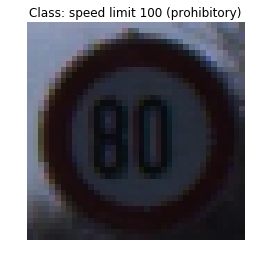

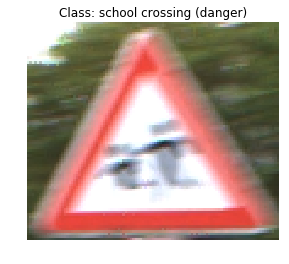

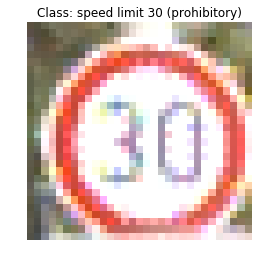

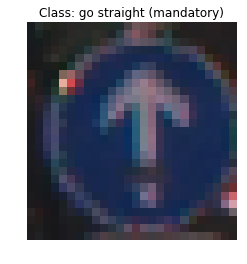

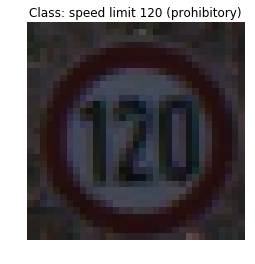

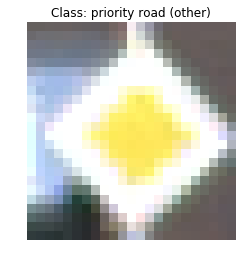

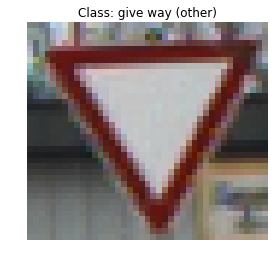

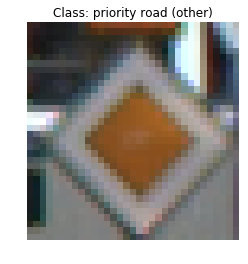

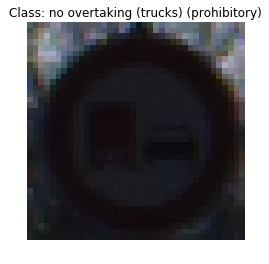

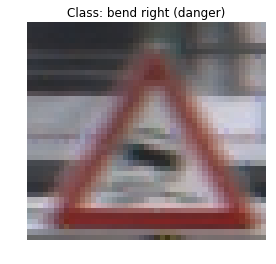

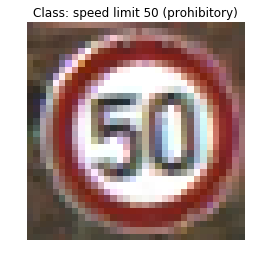

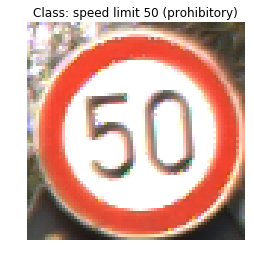

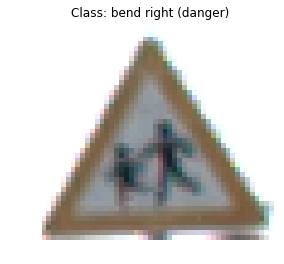

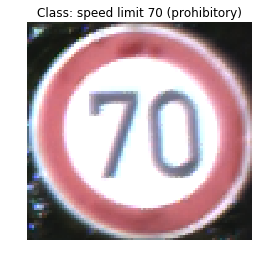

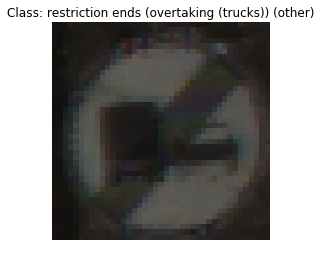

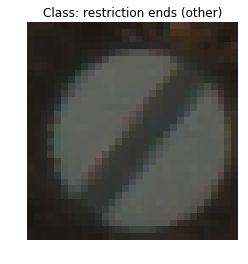

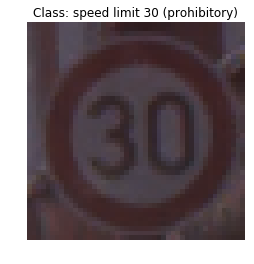

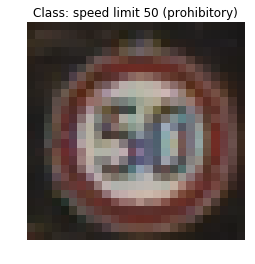

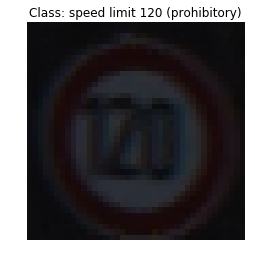

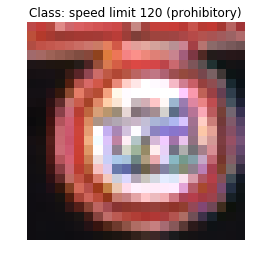

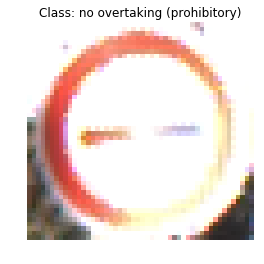

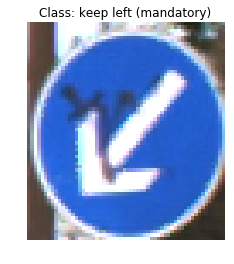

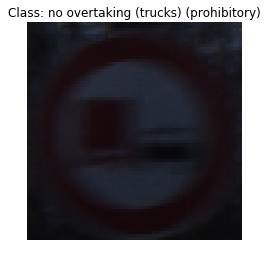

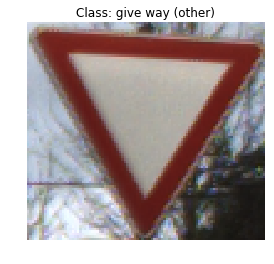

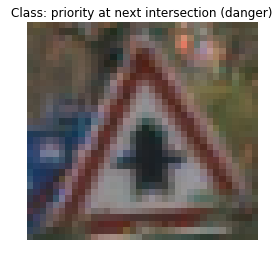

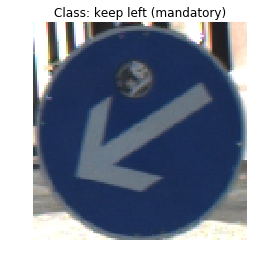

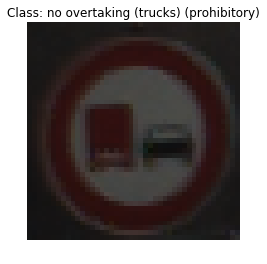

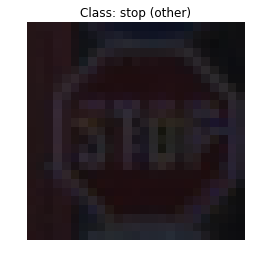

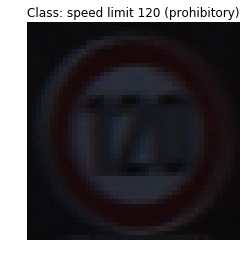

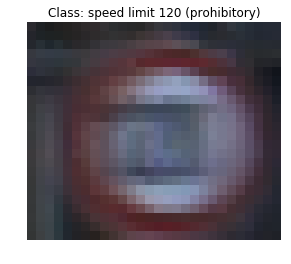

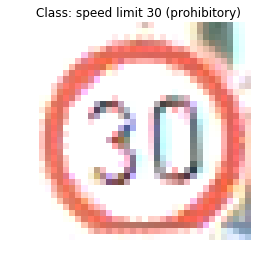

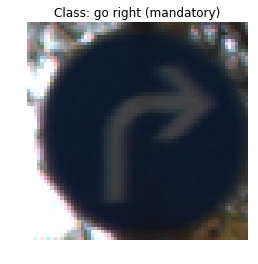

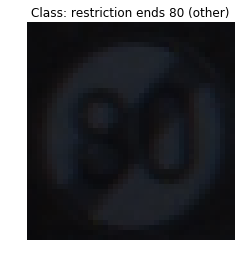

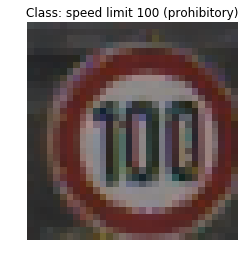

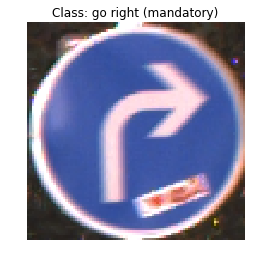

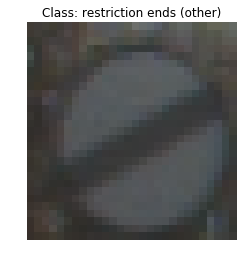

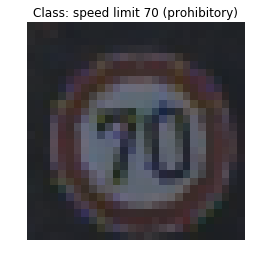

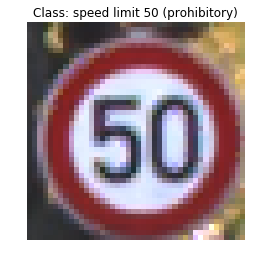

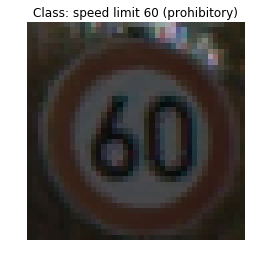

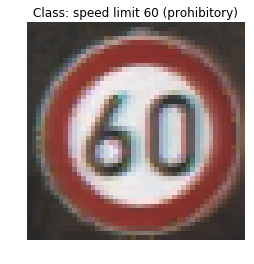

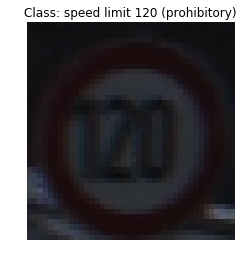

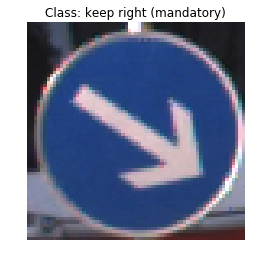

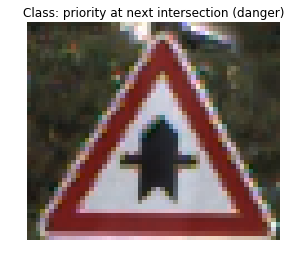

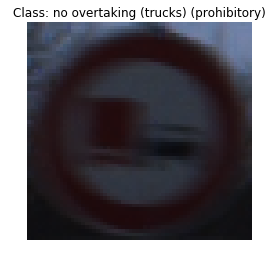

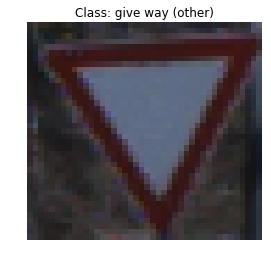

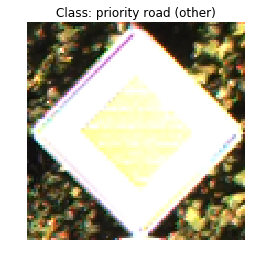

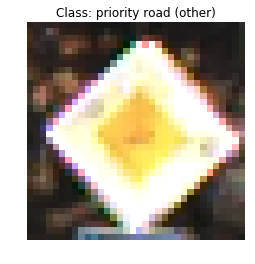

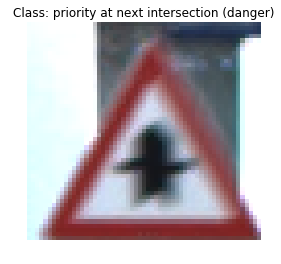

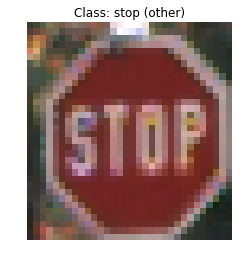

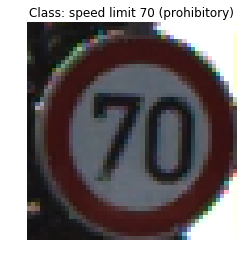

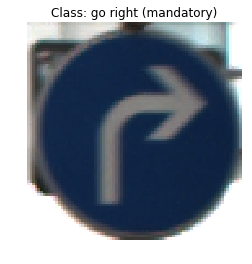

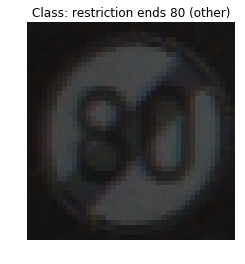

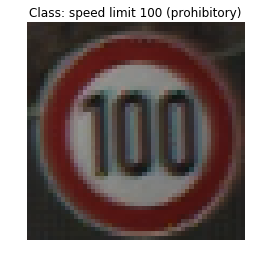

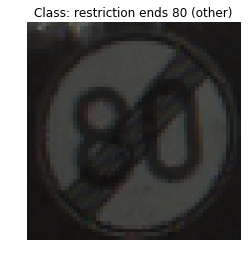

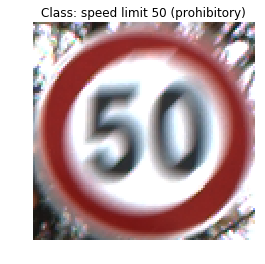

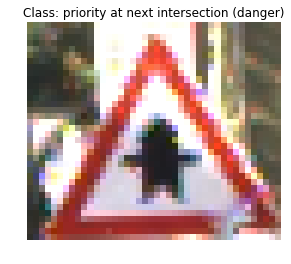

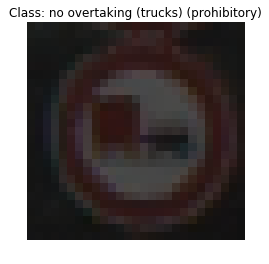

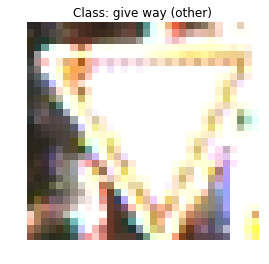

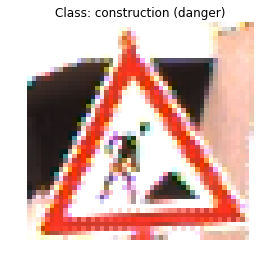

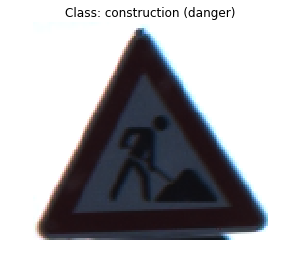

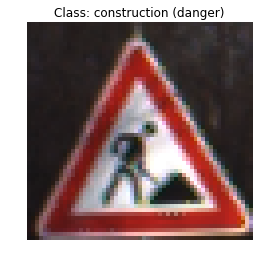

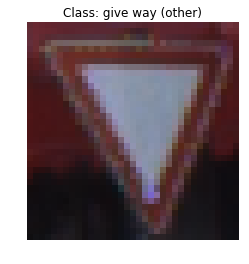

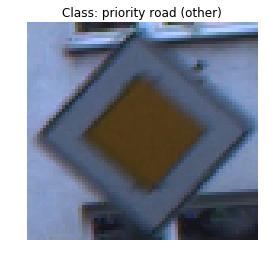

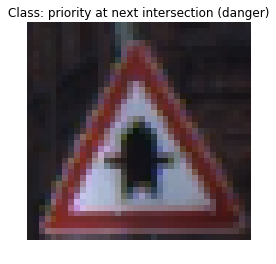

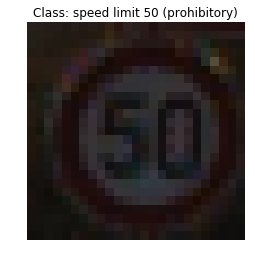

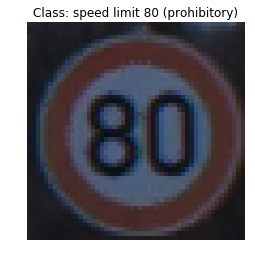

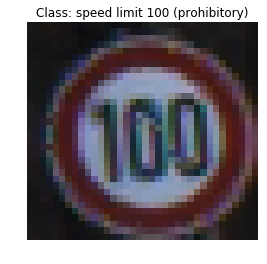

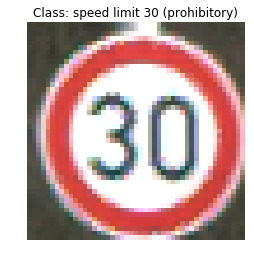

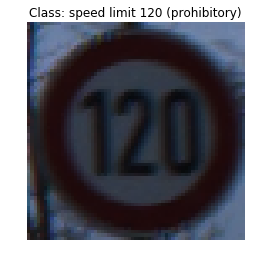

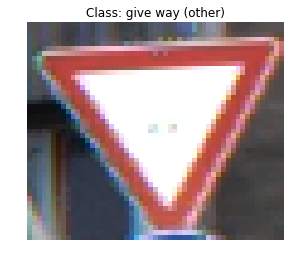

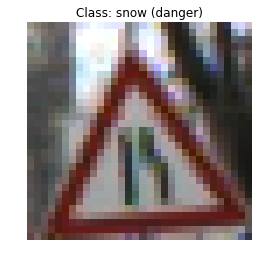

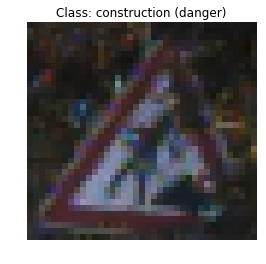

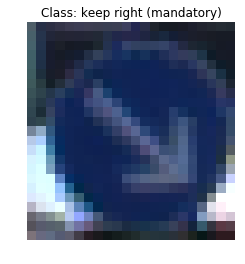

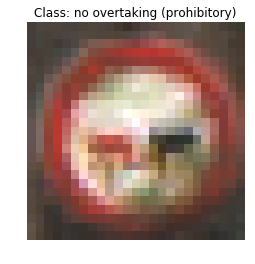

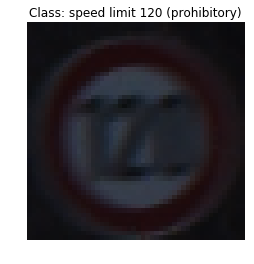

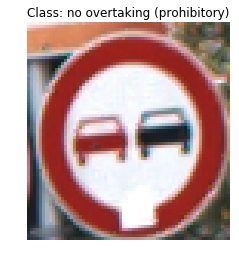

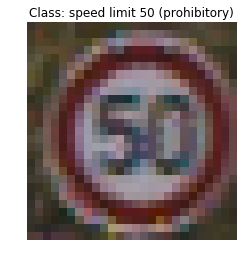

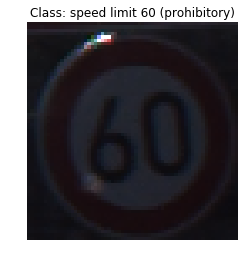

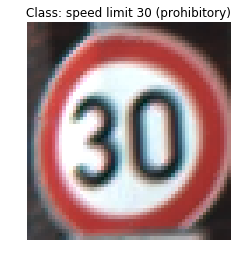

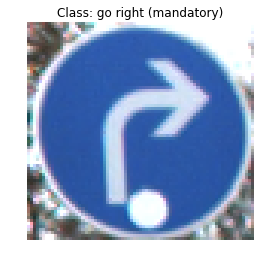

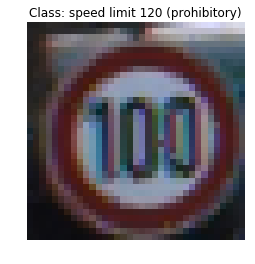

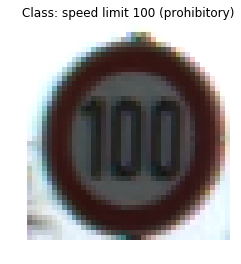

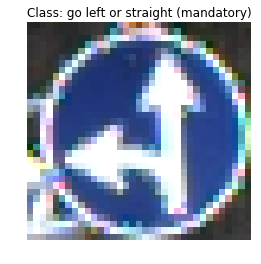

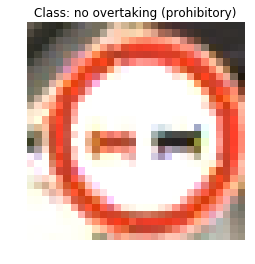

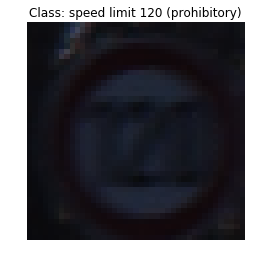

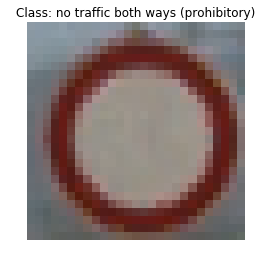

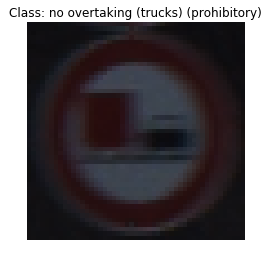

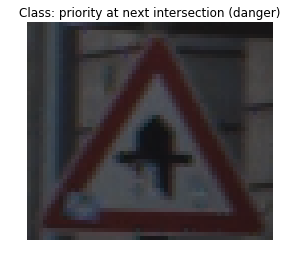

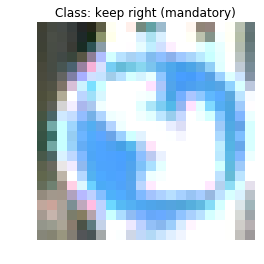

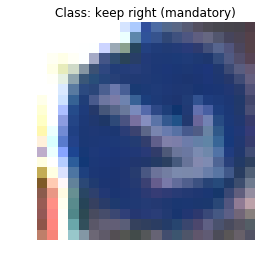

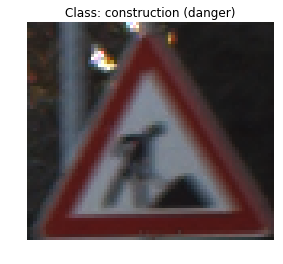

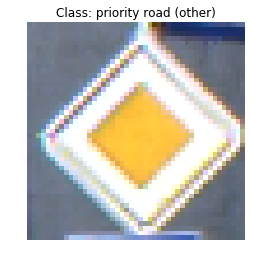

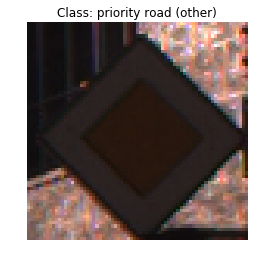

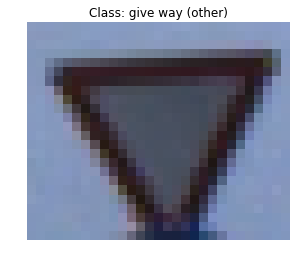

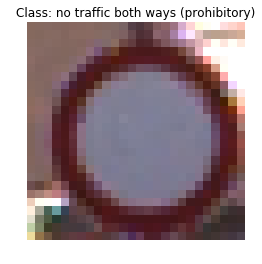

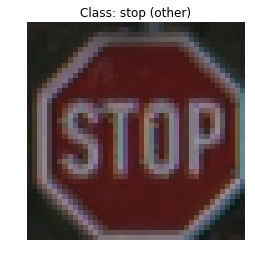

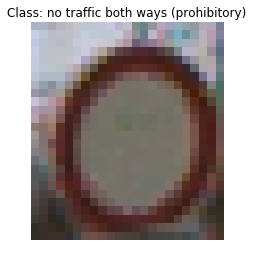

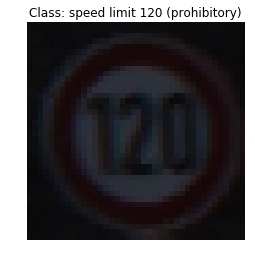

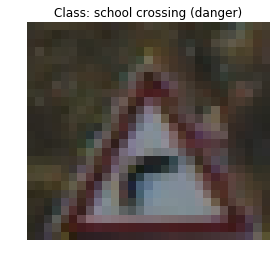

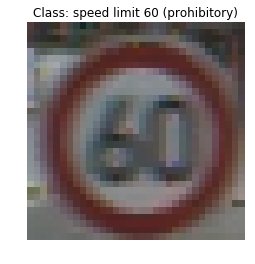

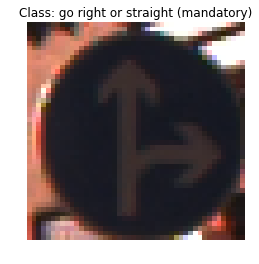

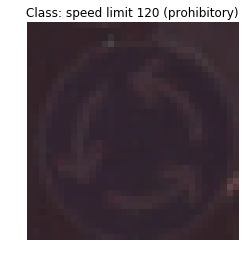

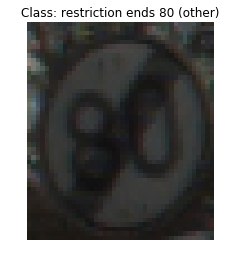

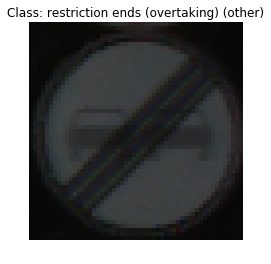

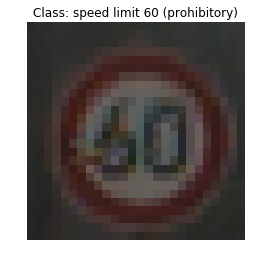

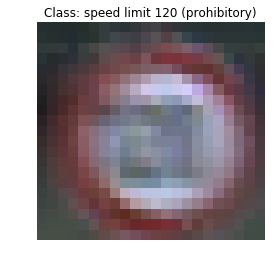

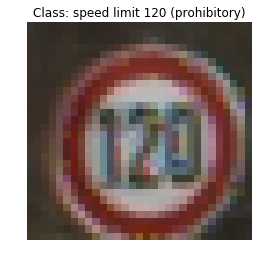

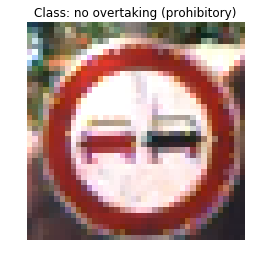

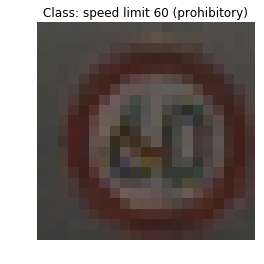

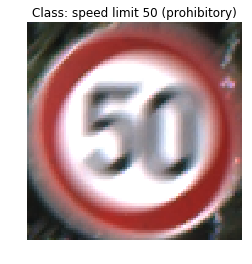

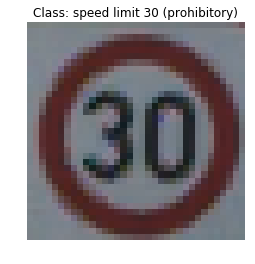

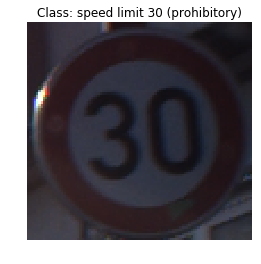

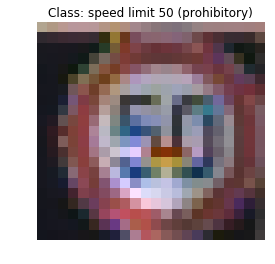

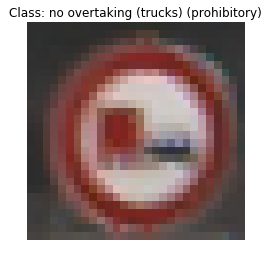

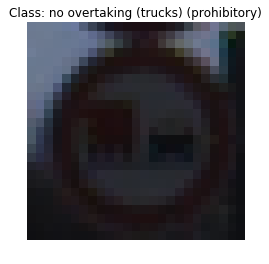

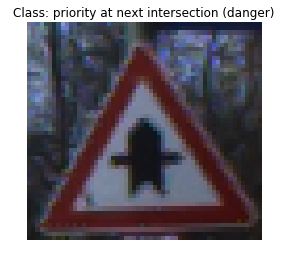

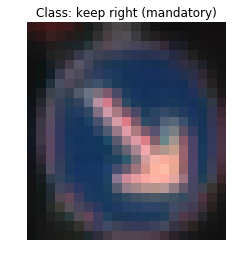

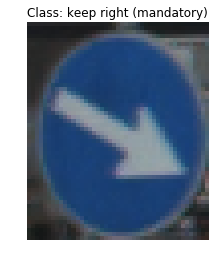

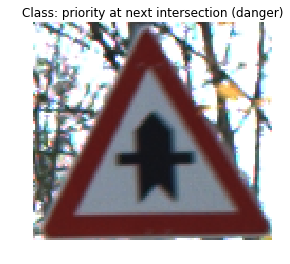

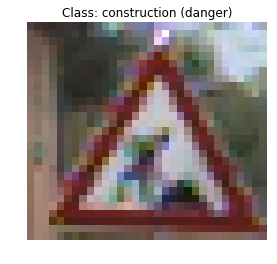

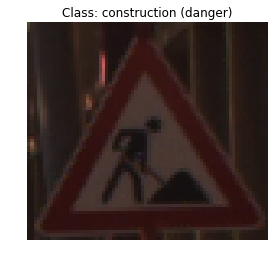

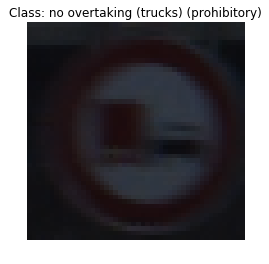

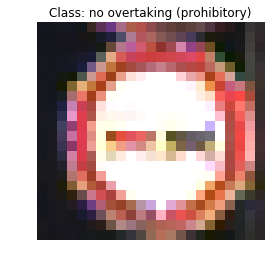

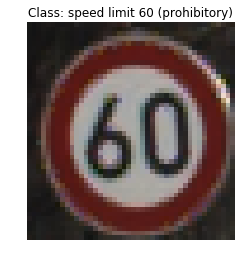

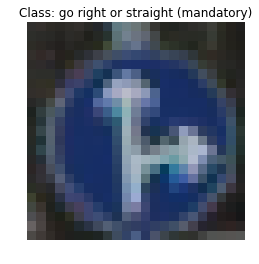

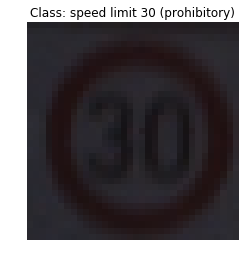

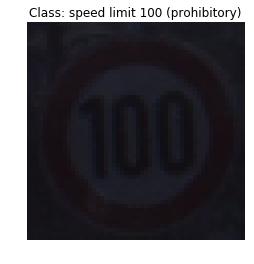

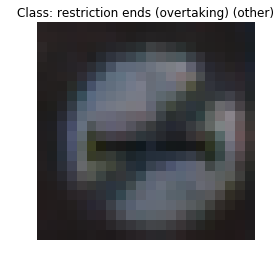

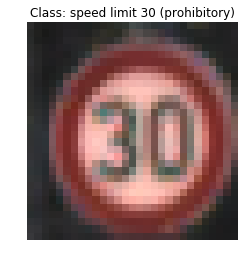

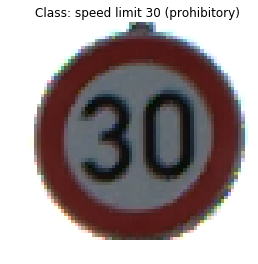

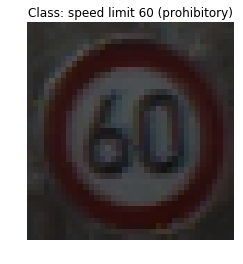

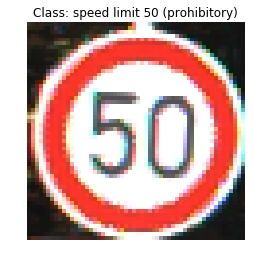

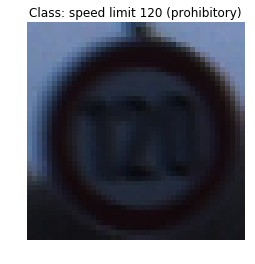

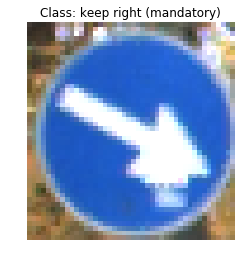

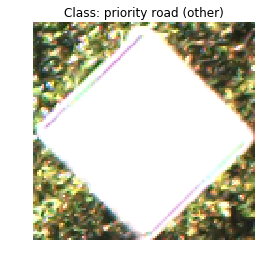

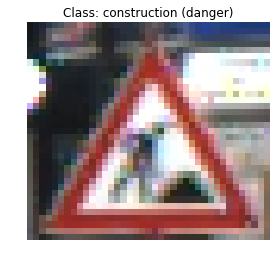

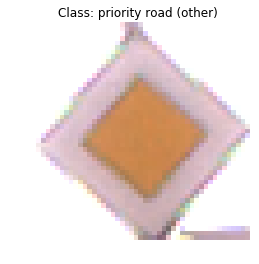

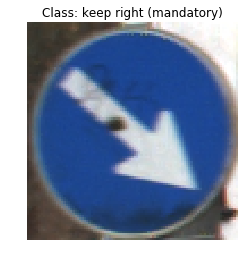

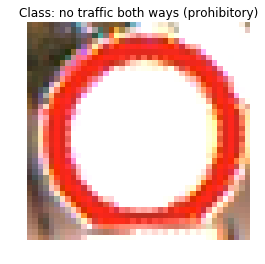

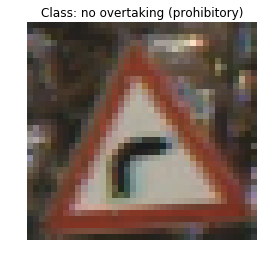

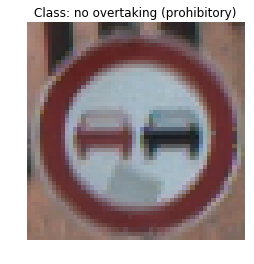

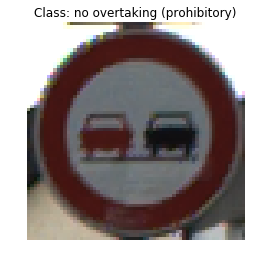

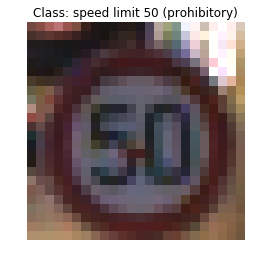

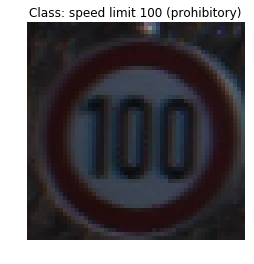

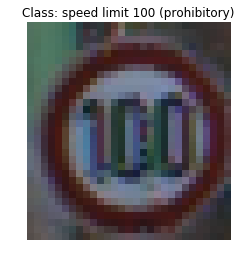

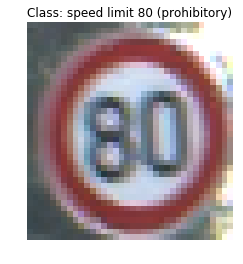

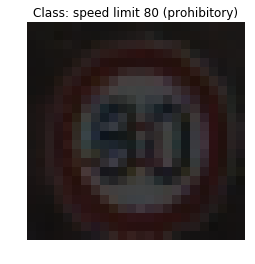

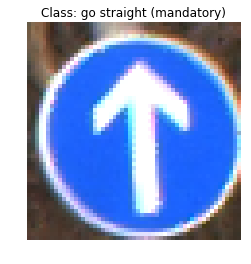

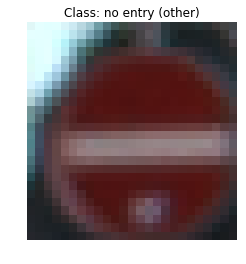

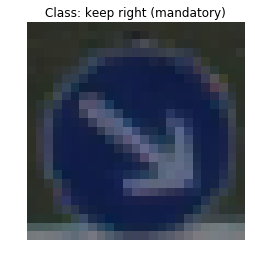

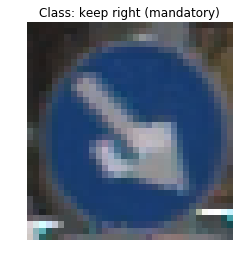

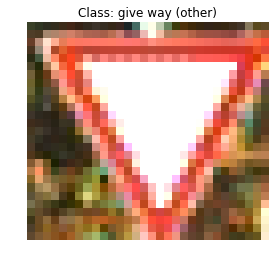

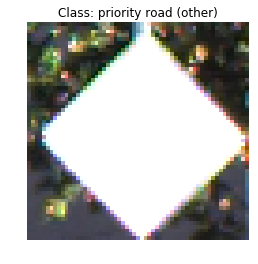

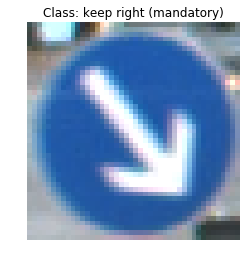

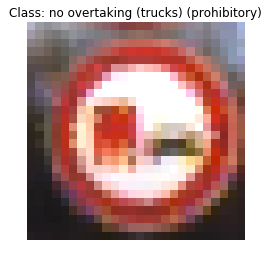

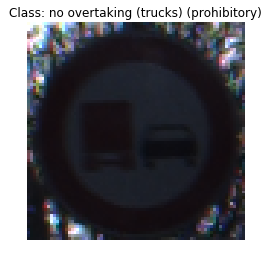

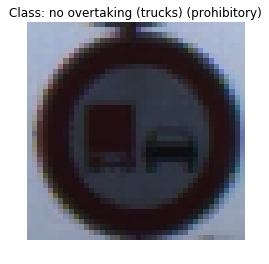

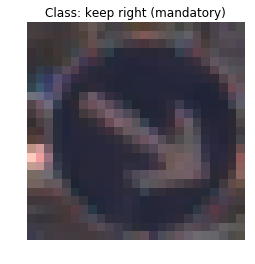

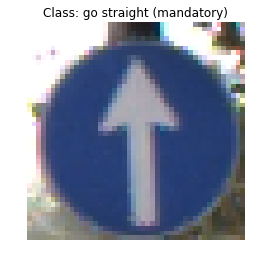

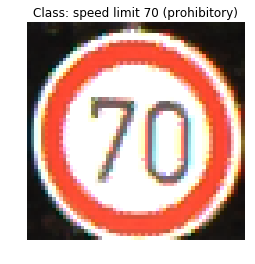

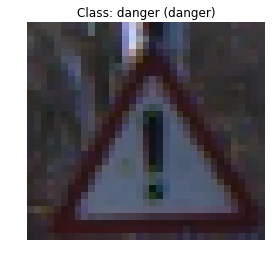

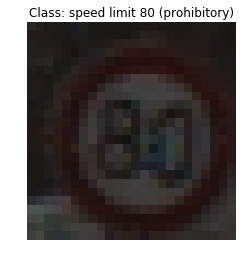

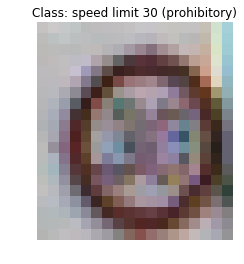

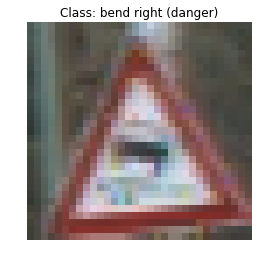

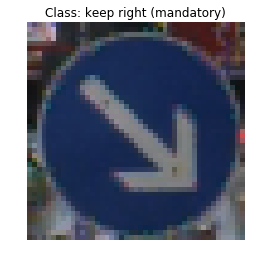

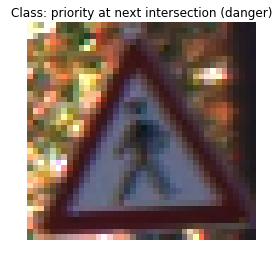

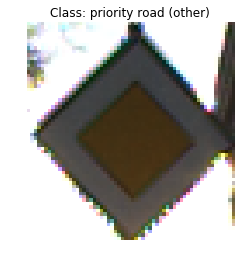

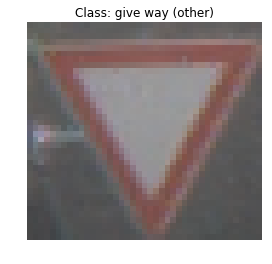

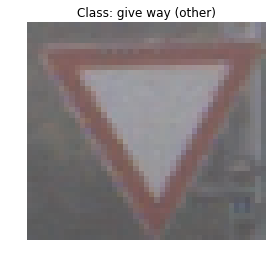

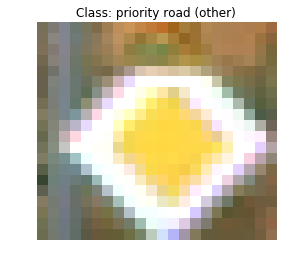

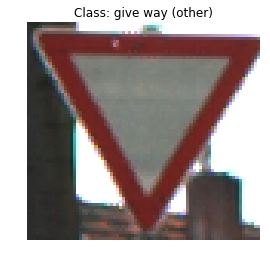

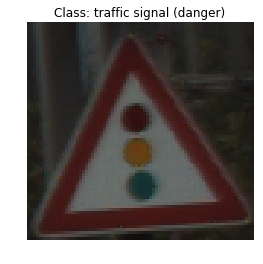

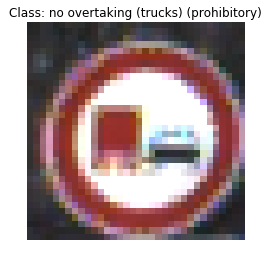

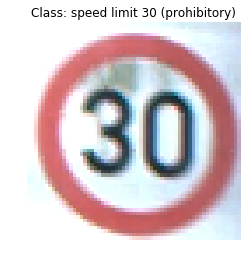

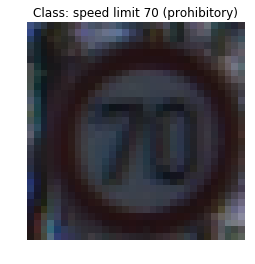

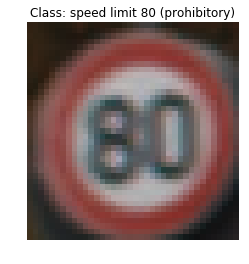

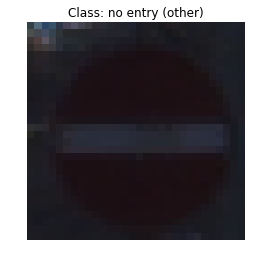

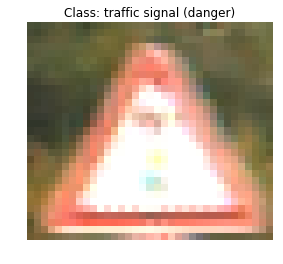

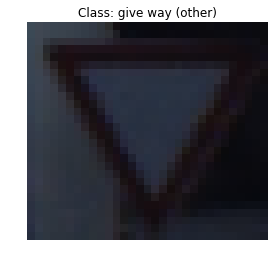

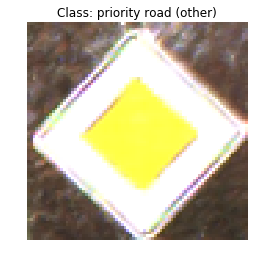

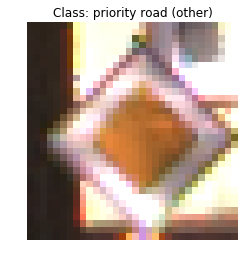

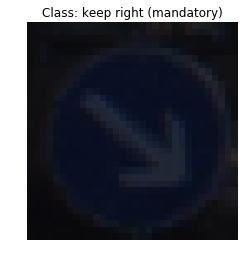

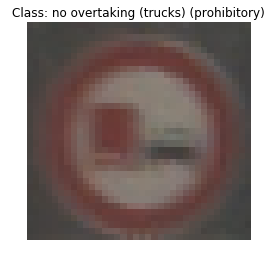

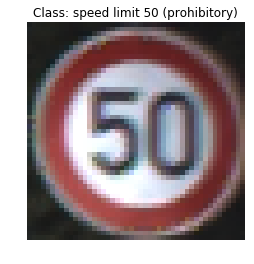

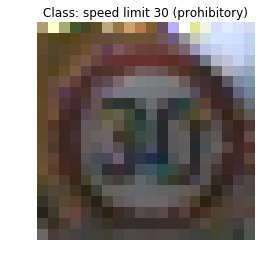

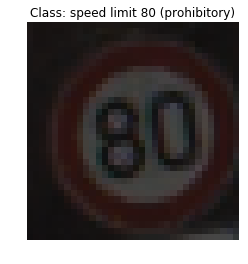

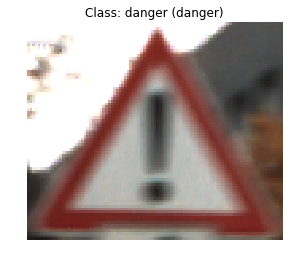

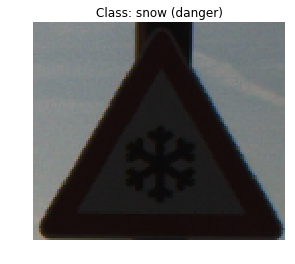

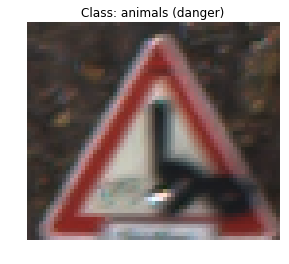

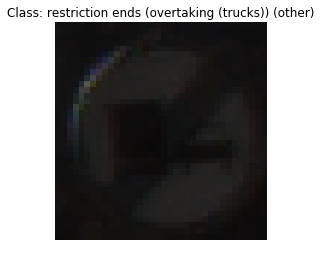

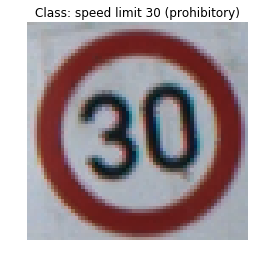

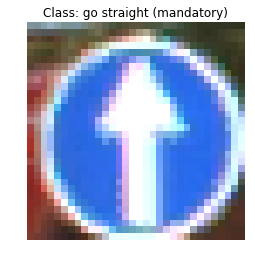

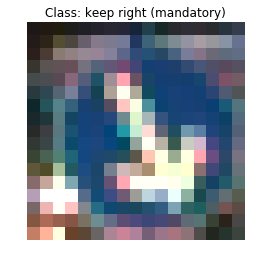

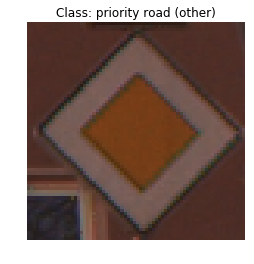

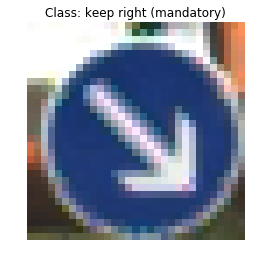

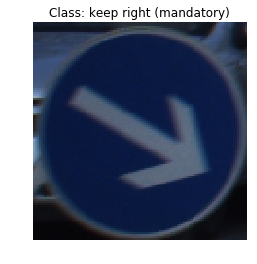

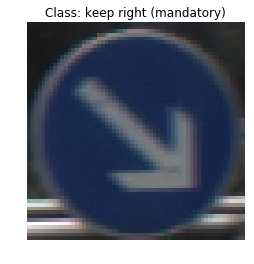

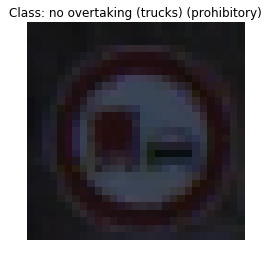

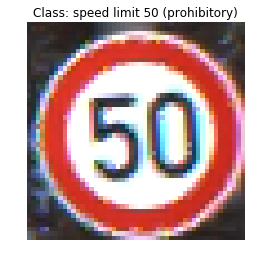

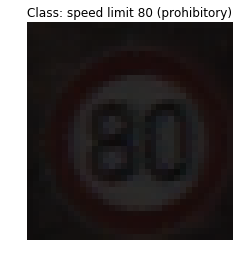

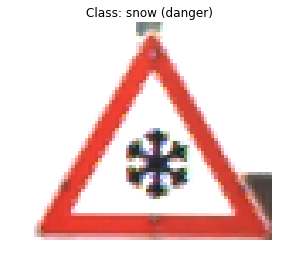

In [295]:
show_predictions(predsx, './images/test', img_names_user)